In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Read CSV

In [2]:
first_model_df = pd.read_csv('first_model_df.csv')

# read csv files
q1_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q1_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q2_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q2_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q3_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q3_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q4_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q4_jul19.csv',skiprows=1,skipfooter=2, engine='python')

# concatenate dataframes
p2p_19 = pd.concat([q1_19, q2_19, q3_19, q4_19], ignore_index=True)
df_19 = p2p_19.copy()

## Model evaluation

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Separate the features and the target variable
X = first_model_df.drop(['ann_realized_return'], axis=1)
y = first_model_df['ann_realized_return']

# Perform k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

# Lists to store the MSE and R-squared values for each fold
mse_values = []
r2_values = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Define the columns to be scaled
    columns_to_scale = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'fico_score',
                        'max_bal_bc', 'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit']

    # Fit the scaler on X_train and transform X_train
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

    # Transform X_test using the fitted scaler from X_train
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the test data
    y_pred = model.predict(X_test)

    # Calculate the MSE and R-squared values
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append the values to the respective lists
    mse_values.append(mse)
    r2_values.append(r2)

# Create a table using pandas
table_data = {
    'Fold': range(1, k+1),
    'MSE': mse_values,
    'R-squared': r2_values
}
table = pd.DataFrame(table_data)

# Calculate the mean MSE and mean R-squared
mean_mse = np.mean(mse_values)
mean_r2 = np.mean(r2_values)

# Add a row for mean values
table.loc[k] = ['Mean', mean_mse, mean_r2]

# Display the table
print(table.to_string(index=False))


Fold      MSE  R-squared
   1 0.007225   0.010316
   2 0.007145   0.010033
   3 0.007146   0.009937
   4 0.007003   0.009204
   5 0.007201   0.010327
Mean 0.007144   0.009963


 ## Business Evaluation


In [4]:
def get_portfolio_return(portfolio_value=10e6, X_test=None, y_test=None, y_pred=None):
    # Select the original loan columns from df_19 using their column names
    results_df = pd.DataFrame(index=X_test.index)
    original_loans = df_19.loc[X_test.index]  

    # Add the selected original loan columns and the predicted annual return values to the DataFrame
    results_df = pd.concat([results_df, original_loans], axis=1)
    results_df['Original Annual Return'] = y_test
    results_df['Predicted Annual Return'] = y_pred

    # sort by grade
    sorted_grade = results_df[['loan_amnt','sub_grade','Original Annual Return','Predicted Annual Return']].sort_values(by='sub_grade', ascending=True)
    # sort by pred
    sorted_pred = results_df[['loan_amnt','sub_grade','Original Annual Return','Predicted Annual Return']].sort_values(by='Predicted Annual Return', ascending=False)

    # portfolio sub grade
    sorted_grade['Running Total Loan Amount'] = sorted_grade['loan_amnt'].cumsum()
    sorted_grade = sorted_grade[sorted_grade['Running Total Loan Amount'] <= portfolio_value]

    # portfolio pred
    sorted_pred['Running Total Loan Amount'] = sorted_pred['loan_amnt'].cumsum()
    sorted_pred = sorted_pred[sorted_pred['Running Total Loan Amount'] <= portfolio_value]

    # grade
    total_return_grade = sum(sorted_grade['loan_amnt'] * (1 + sorted_grade['Original Annual Return']))
    total_invest_grade = sorted_grade['Running Total Loan Amount'].iloc[-1]
    realized_return_grade = total_return_grade / total_invest_grade - 1

    # pred
    total_return_pred = sum(sorted_pred['loan_amnt'] * (1 + sorted_pred['Original Annual Return']))
    total_invest_pred = sorted_pred['Running Total Loan Amount'].iloc[-1]
    realized_return_pred = total_return_pred / total_invest_pred - 1


    # lift
    lift = realized_return_pred - realized_return_grade

    return realized_return_grade, realized_return_pred, lift

## Splitting, Scaling and training

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Separate the features and the target variable
X = first_model_df.drop('ann_realized_return', axis=1)
y = first_model_df['ann_realized_return']

# Perform k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

portfolio_values = [5, 10, 20, 50, 100, 200, 400, 500,750,1000]  # Portfolio values in million
lift_values = np.zeros(len(portfolio_values))
return_pred_values = np.zeros(len(portfolio_values))
return_subgrades_values = np.zeros(len(portfolio_values))

# Folds
for i, portfolio_value in enumerate(portfolio_values):
    lift_sum = 0
    return_pred_sum = 0
    return_subgrade_sum = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a StandardScaler object
        scaler = StandardScaler()

        # Define the columns to be scaled
        columns_to_scale = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'fico_score',
                            'max_bal_bc', 'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit']

        # Fit the scaler on X_train and transform X_train
        X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

        # Transform X_test using the fitted scaler from X_train
        X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

        # Create a linear regression model
        model = LinearRegression()

        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Predict the target variable for the test data
        y_pred = model.predict(X_test)

        # Calculate and display the portfolio return and lift
        realized_return_grade, realized_return_pred, lift = get_portfolio_return(portfolio_value=portfolio_value * 1e6, X_test=X_test, y_test=y_test, y_pred=y_pred)
        lift_sum += lift
        return_pred_sum += realized_return_pred
        return_subgrade_sum += realized_return_grade

    avg_lift = lift_sum / k
    avg_return_pred = return_pred_sum / k
    avg_subgrade_return = return_subgrade_sum / k

    lift_values[i] = avg_lift
    return_pred_values[i] = avg_return_pred
    return_subgrades_values[i] = avg_subgrade_return


## Results

In [8]:
# Create a DataFrame with the portfolio values as index and columns for average return predicted and lift
results_df = pd.DataFrame(index=portfolio_values)
results_df.index.name = "Portfolio Value (million)"

# Fill the DataFrame with the average return predicted and lift values
results_df["AVG Model-based portfolio return (%)"] = np.round(return_pred_values *100, 2)
results_df["AVG Subgrade-based portfolio return (%)"] = np.round(return_subgrades_values*100,2)
results_df["AVG Lift over sub-grade selection (%)"] = np.round(lift_values*100, 2)

# Display the DataFrame
display(results_df)


,AVG Model-based portfolio return (%),AVG Subgrade-based portfolio return (%),AVG Lift over sub-grade selection (%)
Portfolio Value (million),,,
5,3.54,2.74,0.79
10,3.54,2.81,0.73
20,3.48,2.66,0.82
50,3.52,2.76,0.76
100,3.51,2.69,0.82
200,3.44,2.70,0.75
400,3.29,2.66,0.62
500,3.20,2.66,0.54
750,2.83,2.66,0.17


### portfolios return

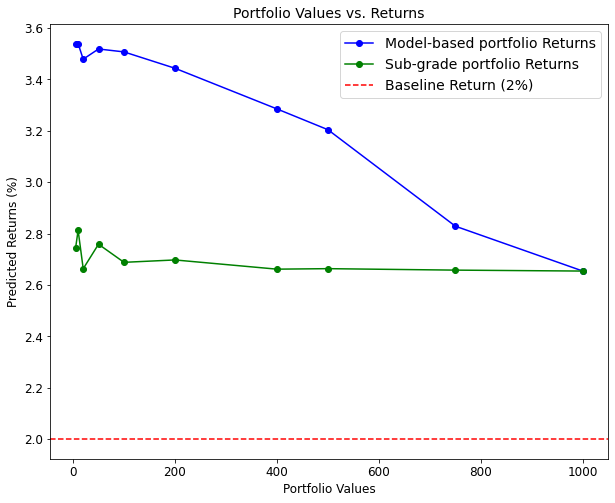

In [9]:
# Plot the portfolio values and predicted returns
plt.figure(figsize=(10, 8))
plt.plot(portfolio_values, return_pred_values*100, marker='o', linestyle='-', color='blue', label='Model-based portfolio Returns')
plt.plot(portfolio_values, return_subgrades_values*100, marker='o', linestyle='-', color='green', label='Sub-grade portfolio Returns')

# Add a red dashed line at 2%
plt.axhline(y=2, color='red', linestyle='--', label='Baseline Return (2%)')

# Set the axis labels and title with larger font size
plt.xlabel('Portfolio Values', fontsize=12)
plt.ylabel('Predicted Returns (%)', fontsize=12)
plt.title('Portfolio Values vs. Returns', fontsize=14)

# Add a legend
plt.legend(fontsize=14)

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


### Lift over sub-grade based portfolio

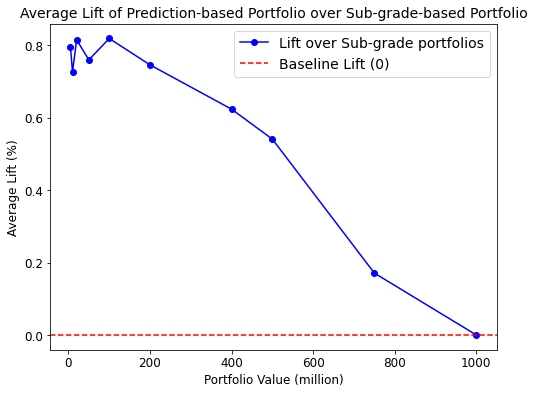

In [10]:
# Plot the lift values
plt.figure(figsize=(8, 6))
plt.plot(portfolio_values, lift_values*100, marker='o', linestyle='-', color='blue', label='Lift over Sub-grade portfolios')

# Add a red dashed line at 0
plt.axhline(y=0, color='red', linestyle='--', label='Baseline Lift (0)')

# Set the axis labels and title with larger font size
plt.xlabel('Portfolio Value (million)', fontsize=12)
plt.ylabel('Average Lift (%)', fontsize=12)
plt.title('Average Lift of Prediction-based Portfolio over Sub-grade-based Portfolio', fontsize=14)

# Add a legend
plt.legend(fontsize=14)

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()
